In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, shutil
import statistics
import json 
import requests
from difflib import SequenceMatcher
import sys
from datetime import date, datetime, timedelta


#sys.path.insert(1, '/home/marinedjaffardjy/Documents/wf_features/src/parsing')
#import parsing_snkmk as ps
#import get_characteristics as t
import json

### Intro
Dans ce notebook, j'ai cherché à visualiser la réutilisation au niveau des workflows.
On considèrera qu'un workflow est réutilisé selon différentes métriques :
- workflow forké
- workflow starred

In [2]:
def importing_json_files(file_wf):
    f_wf = open(file_wf) #informations for nf
    # returns JSON object as
    # a dictionary
    wf = json.load(f_wf)
    f_wf.close
    return wf

#importing the process info
proc_nf = importing_json_files('json/nf_all_proc.json')
proc_nf_tool = importing_json_files('json/nf_proc_tool.json')
proc_snk = importing_json_files('json/snk_rule_info.json')
proc_snk_tool = importing_json_files('json/snk_rule_info_tool.json')


#importing the wf and auth dict (github info)
dict_nf = importing_json_files('json/wf_new_crawl_nextflow.json')
auth_nf = importing_json_files('json/author_clem_nf.json')
dict_snk = importing_json_files('json/wf_crawl_snakemake.json')
auth_snk = importing_json_files('json/author_clem_snk.json')


In [43]:
wf_nf = importing_json_files('/home/marinedjaffardjy/Documents/Code/Investigating_reuse/json/nf_all_wf.json')
#wf_nf_tool = importing_json_files('json/nf_tool_wf.json')
wf_snk = importing_json_files('/home/marinedjaffardjy/Documents/Code/Investigating_reuse/json/wf_snk_added_info.json')

In [3]:
#importing the similarity groups df

df_snk = pd.read_csv("csv/df_groups_snk.csv")
df_sim_snk = pd.read_csv("csv/df_sim_snk.csv")
df_nf = pd.read_csv("csv/df_sim_nf.csv")
df_sim_nf = pd.read_csv("csv/df_groups_snk.csv")
df_sim_snk_lev = pd.read_csv("csv/df_groups_lev_tools_snk.csv")

def grouping_sim_df (df_sim_n, ):
    df_sim = df_sim_n.copy()
    vals = set(df_sim["nb_reuse"])
    tot_group = len(df_sim_n)
    tot_wf = sum(df_sim_n["nb_wf"])
    tot_own = sum(df_sim_n["nb_own"])

    df_sim_group = pd.DataFrame(columns=["nb_reuse", "nb_proc","prop_proc","nb_own","prop_own","nb_wf","prop_wf"])
    for val in vals :
        sec_df = df_sim.loc[df_sim["nb_reuse"]==val]
        nb_proc = len(sec_df)
        prop_proc = nb_proc/tot_group
        nb_own = sum(sec_df["nb_own"])
        prop_own = nb_own/tot_own
        nb_wf = sum(sec_df["nb_wf"])
        prop_wf = nb_wf/tot_wf
        df_sim_group = df_sim_group.append({"nb_reuse":val,
                                            "nb_proc":nb_proc,
                                            "prop_proc":prop_proc*100.0,
                                            "nb_own":nb_own,
                                            "prop_own":prop_own*100.0,
                                            "nb_wf":nb_wf,
                                            "prop_wf":prop_wf*100.0}, ignore_index = True)
    
    return df_sim_group.sort_values(by=["nb_reuse"], ascending=True)

df_snk_lev = grouping_sim_df(df_sim_snk_lev)

In [4]:
#grouping the lev sim groups
def grouping_sim_df_wf (df_sim_n):
    df_sim = df_sim_n.copy()
    vals = set(df_sim["nb_wf"])
    tot_group = len(df_sim_n)

    df_sim_group = pd.DataFrame(columns=["nb_proc","prop_proc","nb_wf"])
    for val in vals :
        sec_df = df_sim.loc[df_sim["nb_wf"]==val]
        nb_proc = len(sec_df)
        prop_proc = nb_proc/tot_group
        df_sim_group = df_sim_group.append({"nb_proc":nb_proc,
                                            "prop_proc":prop_proc*100.0,
                                            "nb_wf":val}, ignore_index = True)
    
    return df_sim_group.sort_values(by=["nb_wf"], ascending=False)

df_snk_lev_wf =grouping_sim_df_wf(df_sim_snk_lev )
df_snk_wf = grouping_sim_df_wf(df_sim_snk )

### Outils des workflows très réutilisés

In [5]:
def find_unique_tools(proc_list):
    tools = []
    for proc in proc_list:
        for tool in proc["tools"]:
            tools.append(tool)
    return list(set(tools))

In [6]:
tools_nf=find_unique_tools(proc_nf)
tools_snk=find_unique_tools(proc_snk)

Is tool use correlated with the mean value of forks, stars, subscribe for the wf that contain them?

In [91]:
def add_tools_info_dict_wf_snk(wfs_dict,wf_list):
    wf_updated = []
    for wf in wf_list:
        name = wf["github_url"].replace('https://github.com/','')
        if(name in wfs_dict.keys()):
            new_wf={}
            new_wf['tools']=[el['name'] for el in wf['tools annotations']]
            new_wf.update(wfs_dict[name])
            wf_updated.append(new_wf)
    return wf_updated

def add_tools_info_dict_wf_nf(wfs_dict,wf_list):
    wf_updated = []
    for wf in wf_list:
        name = wf["author"]+"/"+wf["wf"]
        if(name in wfs_dict.keys()):
            tools=[]
            new_wf={}
            for el in list(wf.keys())[:-2]:
                tools += wf[el]['tools']
            new_wf['tools']=tools
            new_wf.update(wfs_dict[name])
            wf_updated.append(new_wf)
    return wf_updated

In [92]:
dict_nf_tools=add_tools_info_dict_wf_nf(dict_nf,wf_nf)
dict_snk_tools=add_tools_info_dict_wf_snk(dict_snk,wf_snk)

In [101]:
def calculate_age(str_date):
    gvn_date = datetime.strptime(str_date,'%Y-%m-%d').date()
    today = date.today()
    return (today - gvn_date).days

def make_stats_tools_df(tools,wfs):
    stats_tools=pd.DataFrame()
    for tool in tools:
        wfs_cont = []
        for el in wfs:
            if(tool in el["tools"]):
                wfs_cont.append(el)
        stars=[el["stars"] for el in wfs_cont]
        subscribers=[el["subscribers"] for el in wfs_cont]
        forks=[el["forks"] for el in wfs_cont]
        age=[calculate_age(el['creation_date']) for el in wfs_cont]
        last_maint=[calculate_age(el['actual_date']) for el in wfs_cont]
        stats_tools=stats_tools.append({'tool': tool,
                                       'nb_wf': len(wfs_cont),
                                       'forks': np.mean(forks),
                                       'stars': np.mean(stars),
                                       'subscribers': np.mean(subscribers),
                                       'age': np.mean(age),
                                       'last_maintained': np.mean(last_maint)}
                                       ,ignore_index=True)
    return stats_tools.sort_values(by='nb_wf',ascending=False)

In [105]:
df_stats_tools_nf=make_stats_tools_df(tools_nf,dict_nf_tools)
df_stats_tools_snk=make_stats_tools_df(tools_snk,dict_snk_tools)

/home/marinedjaffardjy/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marinedjaffardjy/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [108]:
def display_correlation_tools(df_tools,value,sys):
    ax = df_tools.plot(x='nb_wf', y=value, style='o')
    ax.set_xlabel("number of wf containing a tool")
    ax.set_ylabel("mean nb of "+str(value)+" per wf containing tool")
    ax.set_title('Correlation of tool usage and '+str(value)+' in '+sys)
    return ax


Let us take a look at the correlation between tool use and fork

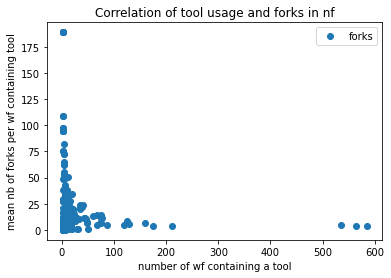

In [109]:
ax1 = display_correlation_tools(df_stats_tools_nf,'forks','nf')

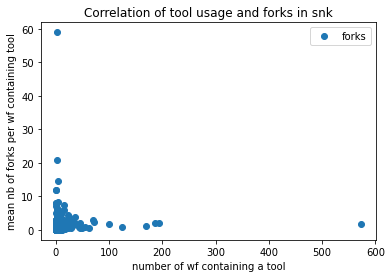

In [110]:
ax1 = display_correlation_tools(df_stats_tools_snk,'forks','snk')

Let us take a look at the correlation between tool use and stars

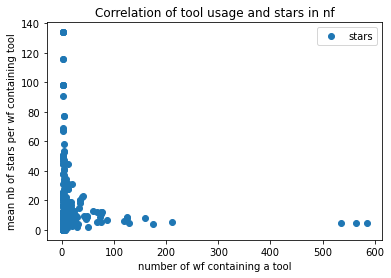

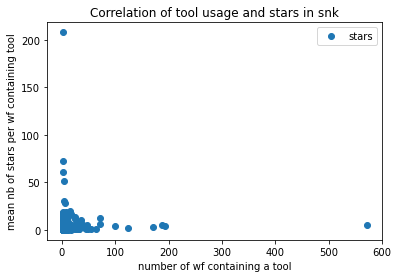

In [112]:
ax1 = display_correlation_tools(df_stats_tools_nf,'stars','nf')
ax2 = display_correlation_tools(df_stats_tools_snk,'stars','snk')

Let us take a look at the correlation between tool use and subscribers

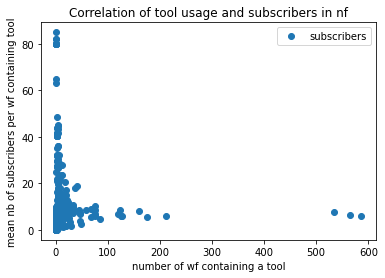

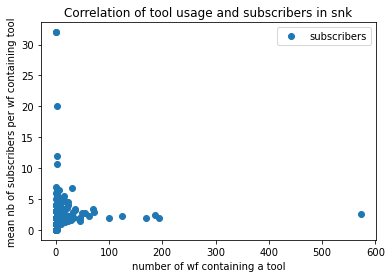

In [111]:
ax1 = display_correlation_tools(df_stats_tools_nf,'subscribers','nf')
ax2 = display_correlation_tools(df_stats_tools_snk,'subscribers','snk')

Let us take a look at the correlation between tool use and date of creation

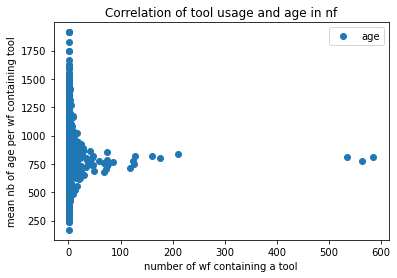

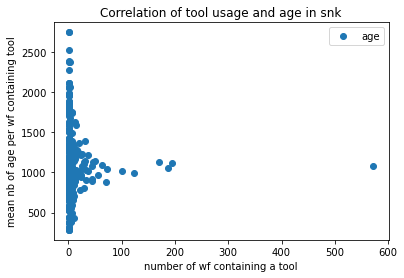

In [113]:
ax1 = display_correlation_tools(df_stats_tools_nf,'age','nf')
ax2 = display_correlation_tools(df_stats_tools_snk,'age','snk')

Let us take a look at the correlation between tool use and last maintenance date

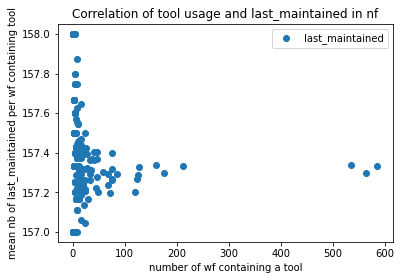

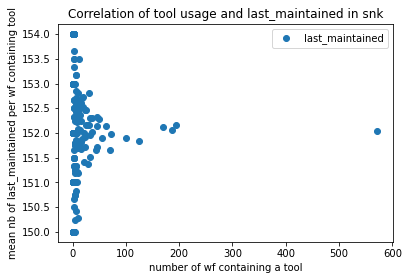

In [114]:
ax1 = display_correlation_tools(df_stats_tools_nf,'last_maintained','nf')
ax2 = display_correlation_tools(df_stats_tools_snk,'last_maintained','snk')